# Matching Atomic Forces using Neural Nets and Gaussians Overlaps 

### Loading Tech Stuff

First we load the python path to LibAtomicSim, which will give us some useful functions

In [1]:
import sys
sys.path.append("/Users/mathieumoog/Documents/LibAtomicSim/Python/")

Then we load the modules, some issues remain with matplotlib on Jupyter, but we'll fix them later.

In [197]:
# NN
import keras
# Descriptor (unused)
import dscribe
# Custom Libs
import cpmd
import filexyz
# Maths
import numpy as np
from scipy.spatial.distance import cdist
# Plots
import matplotlib
matplotlib.use('nbAgg')
import matplotlib.pyplot as plt
# Scalers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA
from keras.regularizers import l2
#['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']
# Need to install some of those stuff at some point

Then we write some functions that are not yet on LibAtomicSim, but should be soon(ish)

In [3]:
def getDistance1Dsq( position1, position2, length):
    dist = position1-position2
    half_length = length*0.5
    if dist > half_length :
        dist -= length
    elif dist < -half_length:
        dist += length
    return dist*dist
def getDistanceOrtho( positions, index1, index2, cell_lengths ):
    dist=0
    for i in range(3):
        dist += getDistance1Dsq( positions[index1,i], positions[index2,i], cell_lengths[i] )
    return np.sqrt(dist)
def getDistance( position1, position2, cell_length ):
    dist=0
    for i in range(3):
        dist += getDistance1Dsq( position1[i], position2[i], cell_lengths[i] )
    return np.sqrt(dist)
def computeDistanceMatrix( positions, cell_lengths):
    nb_atoms = len(positions[:,0])
    matrix = np.zeros(( nb_atoms, nb_atoms ))
    for atom in range(nb_atoms):
        for atom2 in range(atom+1,nb_atoms):
            dist = getDistanceOrtho( positions, atom, atom2, cell_lengths )
            matrix[atom,atom2] = dist
            matrix[atom2,atom] = dist
    return matrix

### Data Parameters

In [4]:
volume=8.82
temperature=3000
nb_type=2
nbC=32
nbO=64
run_nb=1
nb_atoms=nbC+nbO
path_sim = str( "/Users/mathieumoog/Documents/CO2/" + str(volume) + "/" + str(temperature) + "K/" + str(run_nb) + "-run/")

### Loading Trajectory

Here we load the trajectory, including forces and velocities, and convert the positions back into angstroms, while the forces are still in a.u (although we could do everything in a.u.).

In [5]:
cell_lengths = np.ones(3)*volume
ftraj_path = str( path_sim + "FTRAJECTORY" )
positions, velocities, forces = cpmd.readFtraj( ftraj_path, True )
nb_step = positions.shape[0]
ang2bohr = 0.529177
positions = positions*ang2bohr
for i in range(3):
    positions[:,:,i] = positions[:,:,i] % cell_lengths[i]

### Data parametrization

Setting up the parameters for the data construction.

In [326]:
sigma_C = 0.9
sigma_O = 0.9
size_data = nb_step*nbC
dx = 0.1
positions_offset = np.zeros( (6,3), dtype=float )
size_off = 6
n_features=int(2*(size_off+1))
for i,ival in enumerate(np.arange(0,size_off,2)):      
    positions_offset[ ival   , i ] += dx
    positions_offset[ ival+1 , i ] -= dx

Building complete data set, with the small caveat that we don't seek to load all of the positions for time constraints (for now at least).

In [327]:
max_step = 1000
start_step = 1000
stride = 10
size_data = max_step*nbC
data = np.zeros( (max_step*nbC, size_off+1, nb_type ), dtype=float )
for step in np.arange(start_step,stride*max_step+start_step,stride):
    # Distance from all atoms (saves time?)
    matrix = computeDistanceMatrix( positions[step,:,:], cell_lengths)
    for carbon in range(nbC):
        # Data Adress
        add_data = int((step-start_step)/stride)*nbC + carbon
        # C-C
        for carbon2 in range(nbC):
            # Gaussians at atomic site
            data[ add_data, 0, 0 ] += np.exp( -(matrix[carbon,carbon2]*matrix[carbon,carbon2])/(2*sigma_C*sigma_C) )
            # Gaussians with small displacement from site
            if carbon != carbon2:
                for i in range(size_off):
                    dist = getDistance( positions[step, carbon2, :], (positions[step,carbon,:]+positions_offset[i,:])%cell_lengths[0], cell_lengths )
                    data[ add_data, i+1, 0 ] += np.exp( -(dist*dist)/(2*sigma_C*sigma_C) )
        # C-O
        for oxygen in range(nbC,nb_atoms):
            # Gaussians at atomic site
            data[ add_data, 0, 1 ] += np.exp( -(matrix[carbon,oxygen]*matrix[carbon,oxygen])/(2*sigma_O*sigma_O) )
            # Gaussians with small displacement from site
            for i in range(size_off):
                dist = getDistance( positions[step, oxygen,:], (positions[step,carbon,:]+positions_offset[i,:])%cell_lengths[0], cell_lengths )
                data[ add_data, i+1, 1 ] += np.exp( -(dist*dist)/(2*sigma_O*sigma_O) )

### Creating test and train set

Here we focus on the carbon atoms, and we create the input and output shape of the data. The input is created by reshaping the positions array, while the output is simply the forces reshaped. Once this is done, we chose the train et test set by making sure that there is no overlap between them.

In [316]:
nb_data_train = 30000
nb_data_test  = 1000
size_data = max_step*nbC
if nb_data_train + nb_data_test > data.shape[0]:
    print("Datasets larger than amount of available data")
data = data.reshape( size_data, int(2*(size_off+1)) )
choice = np.random.choice( size_data, nb_data_train+nb_data_test, replace=False)
choice_train  = choice[0:nb_data_train]
choice_test = choice[nb_data_train:nb_data_train+nb_data_test]

Here we reshape the data and choose the point for the train and test set making sure that they do not overlap

In [317]:
input_train  = data[ choice_train ]
input_test   = data[ choice_test ]
output_total = forces[start_step:start_step+max_step*stride:stride,0:nbC,0].reshape(size_data,1)
output_train = output_total[ choice_train ]
output_test  = output_total[ choice_test ]

Scaling input and output for the Neural Net

In [318]:
# Creating Scalers
scaler = []  
scaler.append( StandardScaler() )
scaler.append( StandardScaler() )
# Fitting Scalers
scaler[0].fit( input_train  ) 
scaler[1].fit( output_train )    
# Scaling input and output
input_train_scale  = scaler[0].transform( input_train )
input_test_scale   = scaler[0].transform( input_test)
output_train_scale = scaler[1].transform( output_train )
output_test_scale  = scaler[1].transform( output_test )

### Neural Net Structure

Here we set the NN parameters

In [319]:
# Iteration parameters
loss_fct = 'mean_squared_error' # Loss function in the NN
optimizer = 'Adam'                    # Choice of optimizers for training of the NN weights 
learning_rate = 0.001
n_epochs = 5000                  # Number of epoch for optimization?
patience = 100                  # Patience for convergence
restore_weights = True
batch_size = 16
early_stop_metric=['mse']

# Subnetorks structure
activation_fct = 'tanh'  # Activation function in the dense hidden layers
nodes = [15,15,15]

# Dropout rates
dropout_rate_init   = 0.2
dropout_rate_within = 0.5 

Here we create the neural net structure and compile it

In [320]:
# Individual net structure
force_net = keras.Sequential(name='force_net')
#force_net.add( keras.layers.Dropout( dropout_rate_init ) )
for node in nodes:
    force_net.add( keras.layers.Dense( node, activation=activation_fct, kernel_constraint=keras.constraints.maxnorm(3)))
    #force_net.add( keras.layers.Dropout( dropout_rate_within ) )
force_net.add( keras.layers.Dense( 1, activation='linear') )

In [321]:
input_layer = keras.layers.Input(shape=(n_features,), name="gauss_input") 
output_layer = force_net( input_layer )
model = keras.models.Model(inputs=input_layer ,outputs=output_layer )  
model.compile(loss=loss_fct, optimizer=optimizer, metrics=['mse'])

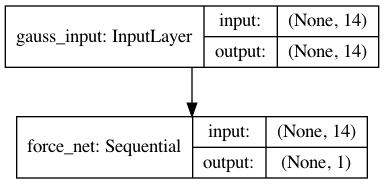

In [322]:
 keras.utils.plot_model(model,to_file="/Users/mathieumoog/network.png", show_shapes=True, show_layer_names=True  )

In [323]:
early_stop = keras.callbacks.EarlyStopping( monitor='val_loss', mode='min', verbose=2, patience=patience, restore_best_weights=True)

In [324]:
history = model.fit( input_train_scale, output_train_scale, validation_data=( input_test_scale, output_test_scale ), epochs=n_epochs, verbose=2, callbacks=[early_stop])

Train on 30000 samples, validate on 1000 samples
Epoch 1/5000
 - 2s - loss: 1.0042 - mse: 1.0042 - val_loss: 0.9732 - val_mse: 0.9732
Epoch 2/5000
 - 1s - loss: 0.9906 - mse: 0.9906 - val_loss: 0.9619 - val_mse: 0.9619
Epoch 3/5000
 - 1s - loss: 0.9807 - mse: 0.9807 - val_loss: 0.9555 - val_mse: 0.9555
Epoch 4/5000
 - 1s - loss: 0.9723 - mse: 0.9723 - val_loss: 0.9486 - val_mse: 0.9486
Epoch 5/5000
 - 1s - loss: 0.9688 - mse: 0.9688 - val_loss: 0.9496 - val_mse: 0.9496
Epoch 6/5000
 - 1s - loss: 0.9678 - mse: 0.9678 - val_loss: 0.9384 - val_mse: 0.9384
Epoch 7/5000
 - 1s - loss: 0.9674 - mse: 0.9674 - val_loss: 0.9355 - val_mse: 0.9355
Epoch 8/5000
 - 1s - loss: 0.9640 - mse: 0.9640 - val_loss: 0.9401 - val_mse: 0.9401
Epoch 9/5000
 - 1s - loss: 0.9633 - mse: 0.9633 - val_loss: 0.9348 - val_mse: 0.9348
Epoch 10/5000
 - 1s - loss: 0.9616 - mse: 0.9616 - val_loss: 0.9416 - val_mse: 0.9416
Epoch 11/5000
 - 1s - loss: 0.9599 - mse: 0.9599 - val_loss: 0.9370 - val_mse: 0.9370
Epoch 12/5000


Epoch 96/5000
 - 1s - loss: 0.8573 - mse: 0.8573 - val_loss: 0.8600 - val_mse: 0.8600
Epoch 97/5000
 - 1s - loss: 0.8585 - mse: 0.8585 - val_loss: 0.8430 - val_mse: 0.8430
Epoch 98/5000
 - 1s - loss: 0.8593 - mse: 0.8593 - val_loss: 0.8444 - val_mse: 0.8444
Epoch 99/5000
 - 1s - loss: 0.8584 - mse: 0.8584 - val_loss: 0.8382 - val_mse: 0.8382
Epoch 100/5000
 - 2s - loss: 0.8565 - mse: 0.8565 - val_loss: 0.8444 - val_mse: 0.8444
Epoch 101/5000
 - 2s - loss: 0.8573 - mse: 0.8573 - val_loss: 0.8456 - val_mse: 0.8456
Epoch 102/5000
 - 2s - loss: 0.8576 - mse: 0.8576 - val_loss: 0.8484 - val_mse: 0.8484
Epoch 103/5000
 - 2s - loss: 0.8544 - mse: 0.8544 - val_loss: 0.8396 - val_mse: 0.8396
Epoch 104/5000
 - 2s - loss: 0.8562 - mse: 0.8562 - val_loss: 0.8361 - val_mse: 0.8361
Epoch 105/5000
 - 2s - loss: 0.8564 - mse: 0.8564 - val_loss: 0.8404 - val_mse: 0.8404
Epoch 106/5000
 - 1s - loss: 0.8540 - mse: 0.8540 - val_loss: 0.8317 - val_mse: 0.8317
Epoch 107/5000
 - 1s - loss: 0.8545 - mse: 0.85

Epoch 191/5000
 - 2s - loss: 0.8336 - mse: 0.8336 - val_loss: 0.8256 - val_mse: 0.8256
Epoch 192/5000
 - 2s - loss: 0.8347 - mse: 0.8347 - val_loss: 0.8348 - val_mse: 0.8348
Epoch 193/5000
 - 2s - loss: 0.8342 - mse: 0.8342 - val_loss: 0.8424 - val_mse: 0.8424
Epoch 194/5000
 - 2s - loss: 0.8337 - mse: 0.8337 - val_loss: 0.8256 - val_mse: 0.8256
Epoch 195/5000
 - 2s - loss: 0.8346 - mse: 0.8346 - val_loss: 0.8368 - val_mse: 0.8368
Epoch 196/5000
 - 2s - loss: 0.8351 - mse: 0.8351 - val_loss: 0.8243 - val_mse: 0.8243
Epoch 197/5000
 - 2s - loss: 0.8356 - mse: 0.8356 - val_loss: 0.8275 - val_mse: 0.8275
Epoch 198/5000
 - 2s - loss: 0.8344 - mse: 0.8344 - val_loss: 0.8377 - val_mse: 0.8377
Epoch 199/5000
 - 2s - loss: 0.8379 - mse: 0.8379 - val_loss: 0.8274 - val_mse: 0.8274
Epoch 200/5000
 - 2s - loss: 0.8330 - mse: 0.8330 - val_loss: 0.8324 - val_mse: 0.8324
Epoch 201/5000
 - 2s - loss: 0.8351 - mse: 0.8351 - val_loss: 0.8315 - val_mse: 0.8315
Epoch 202/5000
 - 2s - loss: 0.8342 - mse: 

<IPython.core.display.Javascript object>


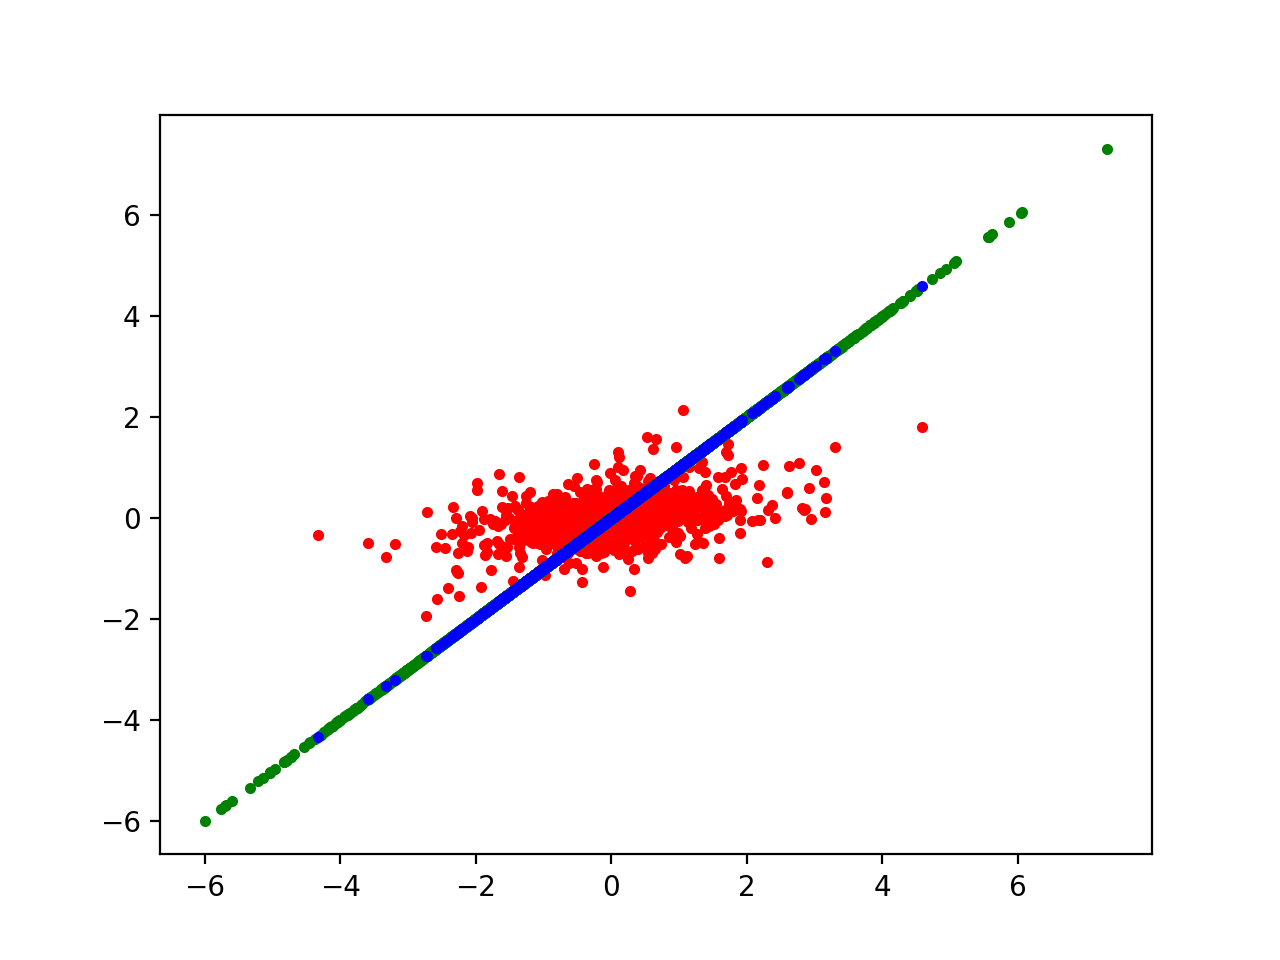

In [325]:
predictions = model.predict( input_test_scale )
plt.plot( output_test_scale, predictions,"r." )
plt.plot( output_train_scale, output_train_scale,"g." )
plt.plot( output_test_scale, output_test_scale,"b." )
plt.show()